In [2]:
# Load packages
import time
from utilities import *

In [ ]:
# Count time
time_start = time.time()

lower = True
ζ_optimal = find_ζ_vol(x_min_RE=1.2,lower=lower,bounds=(-1.1,-0.9),ζ_tol=5e-5,ξ_tol=1e-7,max_iter=100,print_option=True)

# Print out the time spent
time_spent = round(time.time()-time_start,4)
print("Time spent: %s seconds ---" % (time_spent))

In [ ]:
ζ_optimal

In [ ]:
volatility(ζ_optimal,x_min_RE=1.2,lower=lower,ξ_tol=1e-7)

In [3]:
# Min RE
solver = InterDivConstraint(tol=1e-9,max_iter=1000)
solver.g = solver.log_Rw
result = solver.iterate(100.,lower=True)

g1 = np.exp(solver.log_Rw)
g2 = solver.log_Rw

# Calculate volatility, distorted, under min case
# Term 1
moment_bound_cond_g1 = []
for i in np.arange(1,solver.n_states+1,1):
    temp = np.mean(result['N'][solver.pd_lag_indicator[:,i-1]]*g1[solver.pd_lag_indicator[:,i-1]])
    moment_bound_cond_g1.append(temp)
moment_bound_cond_g1 = np.array(moment_bound_cond_g1)
moment_bound_g1 = moment_bound_cond_g1@result['π_tilde']

# Term 2
moment_bound_cond_g2 = []
for i in np.arange(1,solver.n_states+1,1):
    temp = np.mean(result['N'][solver.pd_lag_indicator[:,i-1]]*g2[solver.pd_lag_indicator[:,i-1]])
    moment_bound_cond_g2.append(temp)
moment_bound_cond_g2 = np.array(moment_bound_cond_g2)
moment_bound_g2 = moment_bound_cond_g2@result['π_tilde']

# Combine term 1 and term 2
vol_min = np.log(moment_bound_g1) - moment_bound_g2
vol_cond_min = np.log(moment_bound_cond_g1) - moment_bound_cond_g2

In [4]:
# 20% higher RE, lower bound
vol_lower, vol_cond_lower, vol_empirical, vol_cond_empirical = volatility(-1.0074,x_min_RE=1.2,lower=True,ξ_tol=1e-7)

# 20% higher RE, upper bound
vol_upper, vol_cond_upper,_,_ = volatility(-1.009,x_min_RE=1.2,lower=False,ξ_tol=1e-7)

In [5]:
print("--- volatility (empirical, annualized) ---")
print("State 1: %s " % (np.round(vol_cond_empirical[0]*400,2)))
print("State 2: %s " % (np.round(vol_cond_empirical[1]*400,2)))
print("State 3: %s " % (np.round(vol_cond_empirical[2]*400,2)))
print("Unconditional: %s " % (np.round(vol_empirical*400,2)))
print(" ")
print("--- volatility (min rel entropy, annualized) ---")
print("State 1: %s " % (np.round(vol_cond_min[0]*400,2)))
print("State 2: %s " % (np.round(vol_cond_min[1]*400,2)))
print("State 3: %s " % (np.round(vol_cond_min[2]*400,2)))
print("Unconditional: %s " % (np.round(vol_min*400,2)))
print(" ")
print("--- volatility (lower bound, annualized) ---")
print("State 1: %s " % (np.round(vol_cond_lower[0]*400,2)))
print("State 2: %s " % (np.round(vol_cond_lower[1]*400,2)))
print("State 3: %s " % (np.round(vol_cond_lower[2]*400,2)))
print("Unconditional: %s " % (np.round(vol_lower*400,2)))
print(" ")
print("--- volatility (upper bound, annualized) ---")
print("State 1: %s " % (np.round(vol_cond_upper[0]*400,2)))
print("State 2: %s " % (np.round(vol_cond_upper[1]*400,2)))
print("State 3: %s " % (np.round(vol_cond_upper[2]*400,2)))
print("Unconditional: %s " % (np.round(vol_upper*400,2)))

--- volatility (empirical, annualized) ---
State 1: 1.42 
State 2: 1.16 
State 3: 1.52 
Unconditional: 1.39 
 
--- volatility (min rel entropy, annualized) ---
State 1: 1.48 
State 2: 1.08 
State 3: 1.77 
Unconditional: 1.41 
 
--- volatility (lower bound, annualized) ---
State 1: 1.32 
State 2: 0.91 
State 3: 1.47 
Unconditional: 1.22 
 
--- volatility (upper bound, annualized) ---
State 1: 1.66 
State 2: 1.27 
State 3: 2.11 
Unconditional: 1.62 


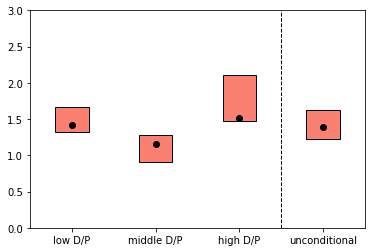

In [13]:
import matplotlib.pyplot as plt

conditioning = ['low D/P', 'middle D/P', 'high D/P', 'unconditional']
min_entropy_implied = np.array([vol_cond_min[0]*400, vol_cond_min[1]*400, vol_cond_min[2]*400, vol_min*400])
empirical_average = np.array([vol_cond_empirical[0]*400, vol_cond_empirical[1]*400, vol_cond_empirical[2]*400, vol_empirical*400])

# Each number is repeated once in order to form a desirable shape of boxes
low_bound_20 = np.array([vol_cond_lower[0]*400, vol_cond_lower[0]*400, vol_cond_upper[0]*400, vol_cond_upper[0]*400]) 
middle_bound_20 = np.array([vol_cond_lower[1]*400, vol_cond_lower[1]*400, vol_cond_upper[1]*400, vol_cond_upper[1]*400])
high_bound_20 = np.array([vol_cond_lower[2]*400,vol_cond_lower[2]*400,vol_cond_upper[2]*400,vol_cond_upper[2]*400])
unconditional_bound_20 = np.array([vol_lower*400, vol_lower*400, vol_upper*400, vol_upper*400])

fig, ax = plt.subplots()
bplot = ax.boxplot(np.vstack((low_bound_20, middle_bound_20, high_bound_20, unconditional_bound_20)).T,
               usermedians = min_entropy_implied, #override the automatically calculated median
               labels = conditioning, widths = 0.4, 
               medianprops = dict(linestyle='-.', linewidth = 0, color = 'black'),
               patch_artist = True)

for box in bplot['boxes']:
    box.set(facecolor = 'salmon')

splot = ax.scatter(x = np.arange(1, 5), y = empirical_average, c = 'black',zorder=10)

ax.axvline(x = 3.5, color = 'black', linestyle = '--', linewidth = 1)

ax.set_ylim(0.,3.)

plt.show()
    
fig.savefig("volatility_full_20%.png",dpi=100)